# Impact Assessment of Data Poisoning Attacks on Collaborative Intrusion Detection Systems using Federated Learning

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib
from matplotlib.backends.backend_pgf import FigureCanvasPgf

# Make the interactive backend as PDF
matplotlib.backend_bases.register_backend("pdf", FigureCanvasPgf)

fontsize = 9
matplotlib.rcParams.update({
    "pgf.texsystem": "lualatex",
    "font.family": "serif",
    "text.usetex": True,
    "pgf.rcfonts": False,
    "font.size": fontsize - 1,
    "axes.titlesize": fontsize - 1,
    "axes.labelsize": fontsize - 2,
    "xtick.labelsize": fontsize - 2,
    "ytick.labelsize": fontsize - 2,
    "legend.fontsize": fontsize - 2,
    "legend.frameon": False,
    "lines.linewidth": 1,
    "lines.markersize": 3,
    "axes.titley": 0,
    "axes.titlepad": -25,
})


def figsize(x, y, two_column=False):
    """Make a figure size with respect to a given width.

    Example:
    --------
    >>> mk_figsize(1, 1)
    (3.3374, 3.3374)
    >>> mk_figsize(1, 2)
    (3.3374, 6.6748)
    >>> mk_figsize(1, 1/3, two_column=True)
    (7.00697, 2.2258)
    """
    columnwidth = 3.3374
    textwidth = 7.00697

    w = textwidth if two_column else columnwidth
    return w * x, w * y


SAVEDIR = "/Users/leo/Workspace/imta/assessment-paper/src/figures/"

## Executive Summary

- **RQ0**: Is the experiment sound?
- **RQ1**: Is the behavior of poisoning attacks predictable?
- **RQ2**: Are there hyperparameter combinations that are beneficial or detrimental in poisoning situation?
- **RQ3**: At what point do poisoning attacks start having an impact? (proportion of poisoned data/clients)
- **RQ4**: Can FL recover from poisoning attacks after model aggregation? How long does it take?
- **RQ5**: Are backdoor attacks realistic in IDS context?
- **RQ6**: Is model similarity enough to detect poisoning attacks? (OPTIONAL)


## RQ4: Can FL recover from poisoning attacks after model aggregation? How long does it take?
- focus on scenario `redemption-3`
	- all distributions: `["10-0","9-1","7-3","5-5","3-7"]`
	- targeted vs untargeted
	- one hyperparameter combination (default `512` / `10-10`, adapt with results of RQ1)

In [19]:
from eiffel.analysis.metrics import choices, display_choices

display_choices(choices("redemption/results/"))

Key,Values
datasets,nfv2_sampled_cicids
distribution,"7-3, 3-7, 5-5, 10-0, 9-1"
epochs,"100_10x10, 100_4x25"
scenario,redemption-3
target,"dos, untargeted"
batch_size,512
partitioner,iid
seed,"1313, 1977, 3263827, 6567, 327, 421, 5555, 501, 2187, 1138"


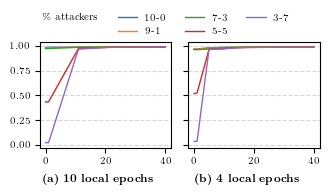

In [41]:
from functools import partial

import numpy as np
from eiffel.analysis.metrics import load_metric, search_results
from eiffel.analysis.plot import Plotable, scale
from matplotlib import pyplot as plt
from matplotlib.axes import Axes

loadfn = partial(load_metric, attr="distributed", dotpath="global.accuracy")

fig, axs = plt.subplots(1, 2, figsize=figsize(1, 0.5), tight_layout=True, sharey=True)

for ax, epochs in zip(axs, [10, 4]):
    ax: Axes
    searchfn = partial(
        search_results,
        "redemption/results/",
        target="untargeted",
        epochs=f".*{epochs}x.*",
        scenario="redemption-3",
    )

    for i, dist in enumerate(["10-0", "9-1", "7-3", "5-5", "3-7"]):
        plotables = scale(
            [Plotable(m, loadfn(m)) for m in searchfn(distribution=dist)],
            100,
        )
        assert len(plotables) == 10
        plotables = [p[epochs - 1 : epochs + 40] for p in plotables]
        ax.plot(
            np.array([p.values for p in plotables]).mean(axis=0),
            label=f"{dist}",
            color=f"C{i}",
        )

    ax.set_title(f"{epochs} local epochs")

abc = "abcdefghijklmnopqrstuvwxyz"
for i, ax in enumerate(axs):
    ax.grid(axis="y", linestyle="--", alpha=0.5)
    ax.set_title(r"\textbf{" f"({abc[i]}) {ax.get_title()}" r"}", x=0.45)
    # box = ax.get_position()
    # ax.set_position([box.x0, box.y0 + box.height * 0.05, box.width, box.height * 0.95])

handles, labels = axs[-1].get_legend_handles_labels()
handles.insert(0, plt.plot([], [], linestyle="")[0])  # fake handle
handles.insert(0, plt.plot([], [], linestyle="")[0])  # fake handle
labels.insert(0, "")
labels.insert(0, r"\% attackers")
lgd = fig.legend(
    handles, labels, loc="upper center", ncol=4, bbox_to_anchor=(0.46, 1.15)
)

fig.savefig(SAVEDIR + "redemption.pdf", bbox_extra_artists=(lgd,), bbox_inches="tight")

The model recovers very quickly from the poisoning attack, even with 70% of attackers. 
This is true even for lower epochs numbers.
The impact of the distribution is not significant, as the model still recovers very quickly.
This can be expected, as the convergence is very fast in the first place, even with the random weights' initialization.

Are there attack types that would be more difficult to recover from?
- May be ML backdoors with trigger features (see the other paper)?
- Model poisoning with backdoors or frozen layers?



<span style="color:red">
<b>TODO</b>: It is currently unclear whether smaller batch sizes would have an impact on the recovery time, as it has one on the poisoning time.
Should we test that?
Intuitively, it should not have an impact, as all participants converge very quickly without attackers.
</span>